<a href="https://colab.research.google.com/github/KCSarkar123/Machine-Learning-Lab-Assignments-/blob/main/ML_Lab5_1050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning using Python : Basic Implementation of Reinforcement Learning**
#Name:- Krishna Chandra Sarkar, Roll:- 002211001050

# Mountain Car with Q-Learning

### Setup and Imports

In [1]:
!pip install pyvirtualdisplay
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import warnings
from IPython.display import HTML
from base64 import b64encode

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

warnings.filterwarnings('ignore')

### Environment and Random Agent (Baseline)

In [2]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space.n}")

frames = []
state, info = env.reset()
done = False

for _ in range(200):
    frame = env.render()
    frames.append(frame)

    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        break

env.close()

video_path = 'mountaincar_random.mp4'
imageio.mimsave(video_path, frames, fps=30)

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=600 controls><source src="{data_url}" type="video/mp4"></video>')

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: 3


### Q-Learning Training

Episode 1000, Average Reward: -199.334
Episode 2000, Average Reward: -192.511
Episode 3000, Average Reward: -183.269
Episode 4000, Average Reward: -174.66
Episode 5000, Average Reward: -163.968
Episode 6000, Average Reward: -168.738
Episode 7000, Average Reward: -168.1
Episode 8000, Average Reward: -174.781
Episode 9000, Average Reward: -173.827
Episode 10000, Average Reward: -160.157
Episode 11000, Average Reward: -160.0
Episode 12000, Average Reward: -175.155
Episode 13000, Average Reward: -158.812
Episode 14000, Average Reward: -157.578
Episode 15000, Average Reward: -167.644
Episode 16000, Average Reward: -166.235
Episode 17000, Average Reward: -166.049
Episode 18000, Average Reward: -165.888
Episode 19000, Average Reward: -163.417
Episode 20000, Average Reward: -174.69


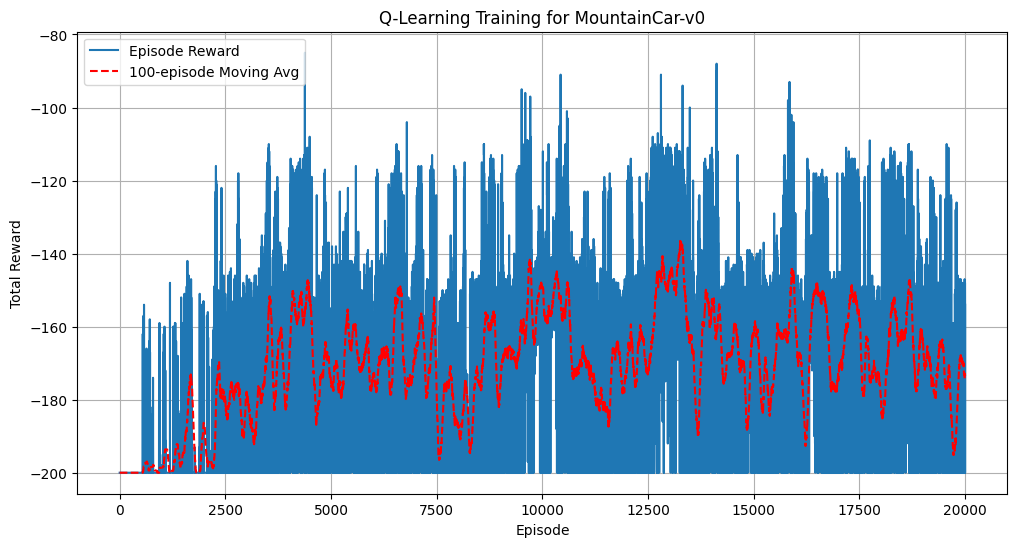

In [3]:
num_bins = [20, 20]

state_bins = [
    np.linspace(-1.2, 0.6, num_bins[0]),
    np.linspace(-0.07, 0.07, num_bins[1])
]

def discretize_state(state):
    """Converts a continuous state (pos, vel) into a discrete tuple (pos_bin, vel_bin)."""
    discretized = []
    for i, s in enumerate(state):
        discretized.append(np.digitize(s, state_bins[i]) - 1)
    return tuple(discretized)

def train_q_learning(env, num_episodes=10000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((num_bins[0], num_bins[1], env.action_space.n))

    rewards = []

    for episode in range(num_episodes):
        state, info = env.reset()
        d_state = discretize_state(state)

        total_reward = 0
        terminated = False
        truncated = False

        while not (terminated or truncated):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[d_state])

            next_state, reward, terminated, truncated, info = env.step(action)
            d_next_state = discretize_state(next_state)

            old_q_value = q_table[d_state][action]
            max_future_q = np.max(q_table[d_next_state])

            new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * max_future_q)
            q_table[d_state][action] = new_q_value

            d_state = d_next_state
            total_reward += reward

        rewards.append(total_reward)
        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}, Average Reward: {np.mean(rewards[-1000:])}")

    np.save('q_table_mountaincar.npy', q_table)
    return rewards, q_table

env = gym.make('MountainCar-v0')
rewards, q_table = train_q_learning(env, num_episodes=20000)
env.close()

plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Episode Reward')

moving_avg = [np.mean(rewards[max(0, i-100):i+1]) for i in range(len(rewards))]
plt.plot(moving_avg, color='red', linestyle='--', label='100-episode Moving Avg')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training for MountainCar-v0')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate the Trained Agent

In [4]:
from functools import total_ordering
q_table=np.load('q_table_mountaincar.npy')

env=gym.make('MountainCar-v0', render_mode='rgb_array')

frames=[]
state, info = env.reset()
d_state=discretize_state(state)
total_reward=0


for _ in range(200):
    frame=env.render()
    frames.append(frame)

    action=np.argmax(q_table[d_state])

    next_state, reward, terminated, truncated, info = env.step(action)

    d_state=discretize_state(next_state)
    total_reward+=reward

    if terminated or truncated:
        break

env.close()
print(f"Total reward for trained agent: {total_reward}")

video_path='mountain_trained.mp4'
imageio.mimsave(video_path, frames, fps=30)

mp4=open(video_path,'rb').read()
data_url="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML(f'<video width=600 controls><source src="{data_url}" type="video/mp4"></video>')

Total reward for trained agent: -191.0


# Roulette

### Setup and Imports

In [ ]:
!pip install gymnasium matplotlib -q

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

import matplotlib.pyplot as plt
import os
import warnings
from IPython.display import clear_output

warnings.filterwarnings('ignore')

### Custom Roulette Environment

In [ ]:
class RouletteEnv(gym.Env):
    """
    A simple custom environment for European Roulette (0-36).
    This is a Multi-Armed Bandit problem.
    """
    def __init__(self):
        super().__init__()

        # 5 possible bets (actions)
        self.action_space = spaces.Discrete(5)

        # Only one state: "Ready to bet"
        self.observation_space = spaces.Discrete(1)

        # Payouts: (Bet $1)
        # 1:1 -> Win $1 + get $1 bet back = $2 return. Net profit: +$1
        # 2:1 -> Win $2 + get $1 bet back = $3 return. Net profit: +$2
        # 35:1 -> Win $35 + get $1 bet back = $36 return. Net profit: +$35

        # Payout map: {action: (win_check, net_profit)}
        self.payout_logic = {
            0: (self._is_red, 1),
            1: (self._is_black, 1),
            2: (self._is_odd, 1),
            3: (self._is_dozen1, 2),
            4: (self._is_num7, 35),
        }

        # Number definitions
        self.red_numbers = {1, 3, 5, 7, 9, 12, 14, 16, 18, 19, 21, 23, 25, 27, 30, 32, 34, 36}
        self.black_numbers = {2, 4, 6, 8, 10, 11, 13, 15, 17, 20, 22, 24, 26, 28, 29, 31, 33, 35}
        self.green_number = 0
        self.total_numbers = 37 # (0-36)

    # --- Win Check Functions ---
    def _is_red(self, n): return n in self.red_numbers
    def _is_black(self, n): return n in self.black_numbers
    def _is_odd(self, n): return n != 0 and n % 2 != 0
    def _is_dozen1(self, n): return n >= 1 and n <= 12
    def _is_num7(self, n): return n == 7

    def reset(self, seed=None, options=None):
        # Reset the environment (does nothing, as state is constant)
        super().reset(seed=seed)
        return 0, {} # Return the single state '0'

    def step(self, action):
        # 1. Spin the wheel
        spin_result = self.np_random.integers(0, self.total_numbers) # 0-36

        # 2. Assume $1 bet (loss)
        reward = -1

        # 3. Check if the bet won
        win_func, net_profit = self.payout_logic[action]

        if win_func(spin_result):
            # If won, add the original $1 bet back + the net profit
            reward += (1 + net_profit)

        # 4. The episode is always "done" after one spin
        terminated = True
        truncated = False

        # 5. Return (state, reward, done, truncated, info)
        return 0, reward, terminated, truncated, {}

# --- Test the environment ---
env = RouletteEnv()
print("Custom Roulette Environment created.")
print(f"Action Space: {env.action_space.n} (Bets)")
print(f"Observation Space: {env.observation_space.n} (State)")

# Test a step (Bet on Red)
action = 0
state, reward, _, _, _ = env.step(action)
print(f"Bet 'Red', got reward: {reward}")

# Test a step (Bet on 7)
action = 4
state, reward, _, _, _ = env.step(action)
print(f"Bet '7', got reward: {reward}")
env.close()

Custom Roulette Environment created.
Action Space: 5 (Bets)
Observation Space: 1 (State)
Bet 'Red', got reward: -1
Bet '7', got reward: -1


### Q-Learning Training

Training finished.


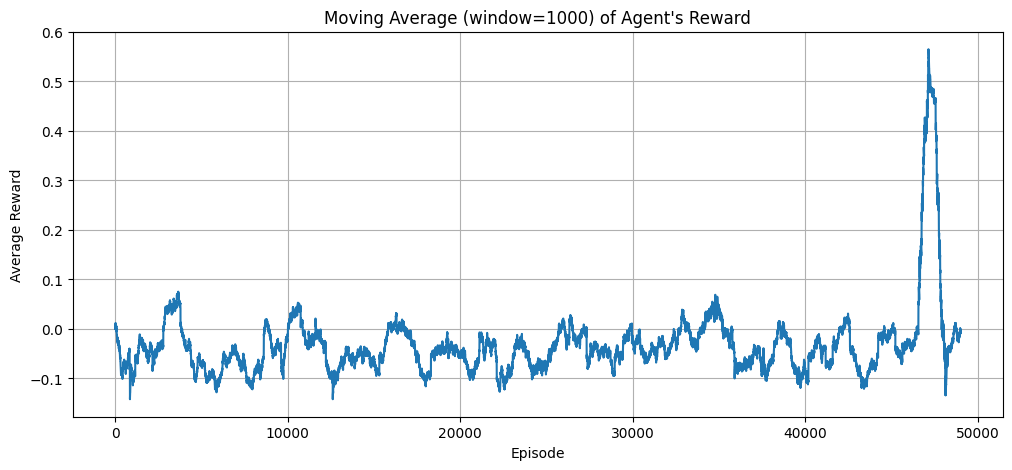

In [ ]:
# --- 1. Hyperparameters ---
num_episodes = 50000
alpha = 0.01        # Learning rate (how much to update Q-value)
gamma = 0.1         # Discount factor (not very important here, as episode is 1 step)
epsilon = 0.1       # Exploration rate (10% of bets will be random)

# --- 2. Initialize Q-Table ---
# Our table has 1 state and 5 actions
num_actions = 5
q_table = np.zeros((1, num_actions))

# For plotting
episode_rewards = []
q_table_history = []

# --- 3. Training Loop ---
env = RouletteEnv()

for episode in range(num_episodes):
    state, info = env.reset()

    # Epsilon-greedy action selection
    if np.random.rand() < epsilon:
        action = env.action_space.sample()  # Explore
    else:
        action = np.argmax(q_table[state])  # Exploit

    # Take the action (spin the wheel)
    next_state, reward, terminated, truncated, info = env.step(action)

    # --- Q-Learning Update ---
    # This is the standard update rule for a multi-armed bandit
    # Q(s,a) = Q(s,a) + alpha * (reward - Q(s,a))
    # "Move the Q-value a small step (alpha) towards the new reward"

    q_table[state, action] = q_table[state, action] + alpha * (reward - q_table[state, action])

    # Store results
    episode_rewards.append(reward)
    if episode % 1000 == 0:
        q_table_history.append(q_table.copy()) # Store a snapshot

env.close()

print("Training finished.")

# --- 4. Plot Moving Average Reward ---
# We calculate a moving average to see the trend
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

avg_rewards = moving_average(episode_rewards, 1000)

plt.figure(figsize=(12, 5))
plt.plot(avg_rewards)
plt.title(f"Moving Average (window=1000) of Agent's Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

### Analysis: What Did the Agent Learn?

--- Final Q-Table (Learned Expected Values) ---
Bet Red: -0.1986
Bet Black: -0.1456
Bet Odd: -0.0221
Bet Dozen 1: -0.1137
Bet Number 7: -0.2276

Theoretical Expected Value for all bets: -1/37 = -0.0270


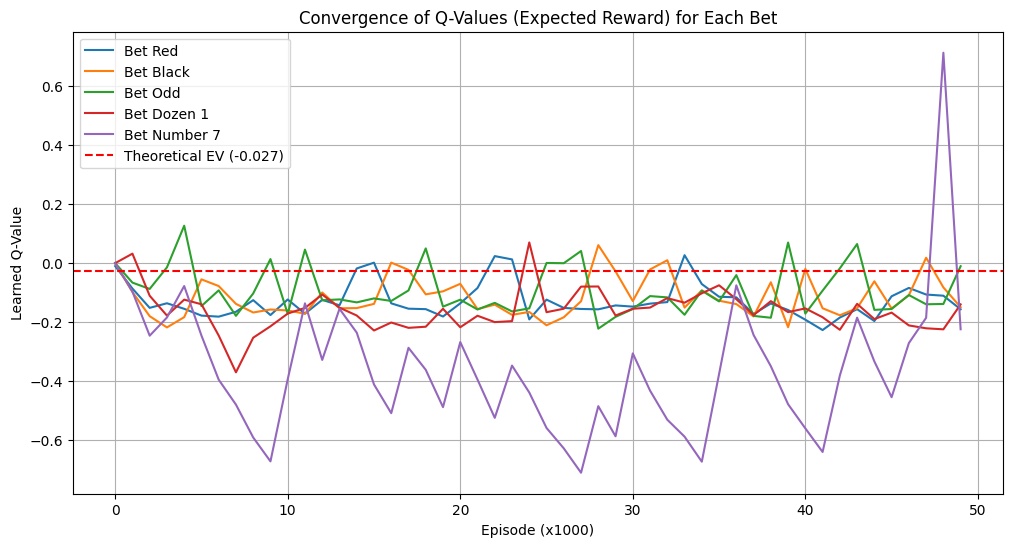

In [ ]:
# --- 1. Print Final Q-Table ---
print("--- Final Q-Table (Learned Expected Values) ---")
bet_names = ["Bet Red", "Bet Black", "Bet Odd", "Bet Dozen 1", "Bet Number 7"]

for i, name in enumerate(bet_names):
    print(f"{name}: {q_table[0, i]:.4f}")

print("\nTheoretical Expected Value for all bets: -1/37 = -0.0270")

# --- 2. Plot Q-Value Convergence ---
q_history = np.array(q_table_history).reshape(-1, num_actions)

plt.figure(figsize=(12, 6))
for i in range(num_actions):
    plt.plot(q_history[:, i], label=bet_names[i])

# Plot the theoretical EV line
plt.axhline(y=-1/37, color='r', linestyle='--', label='Theoretical EV (-0.027)')
plt.title("Convergence of Q-Values (Expected Reward) for Each Bet")
plt.xlabel("Episode (x1000)")
plt.ylabel("Learned Q-Value")
plt.legend()
plt.grid(True)
plt.show()

# Deep Reinforcement Learning (DRL)

## Mountain Car trying to go top a hill

### Setup and Imports

Using device: cuda
Episode 10/500, Reward: -200.00, Epsilon: 0.95
Episode 20/500, Reward: -200.00, Epsilon: 0.90
Episode 30/500, Reward: -200.00, Epsilon: 0.86
Episode 40/500, Reward: -200.00, Epsilon: 0.82
Episode 50/500, Reward: -200.00, Epsilon: 0.78
Episode 60/500, Reward: -200.00, Epsilon: 0.74
Episode 70/500, Reward: -200.00, Epsilon: 0.70
Episode 80/500, Reward: -200.00, Epsilon: 0.67
Episode 90/500, Reward: -200.00, Epsilon: 0.64
Episode 100/500, Reward: -200.00, Epsilon: 0.61
Episode 110/500, Reward: -200.00, Epsilon: 0.58
Episode 120/500, Reward: -200.00, Epsilon: 0.55
Episode 130/500, Reward: -200.00, Epsilon: 0.52
Episode 140/500, Reward: -200.00, Epsilon: 0.50
Episode 150/500, Reward: -200.00, Epsilon: 0.47
Episode 160/500, Reward: -200.00, Epsilon: 0.45
Episode 170/500, Reward: -200.00, Epsilon: 0.43
Episode 180/500, Reward: -200.00, Epsilon: 0.41
Episode 190/500, Reward: -200.00, Epsilon: 0.39
Episode 200/500, Reward: -200.00, Epsilon: 0.37
Episode 210/500, Reward: -200.

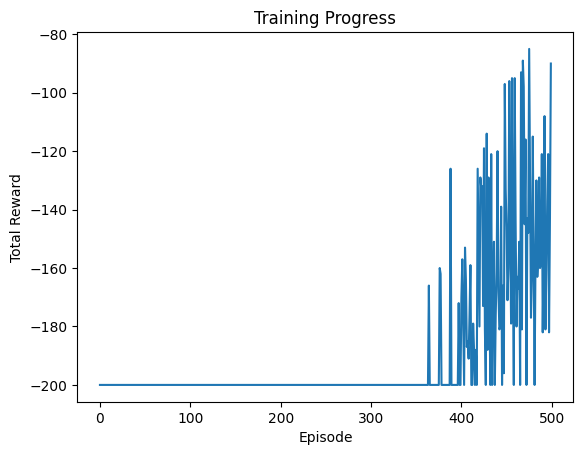

In [ ]:
!pip install gym
!pip install torch
!pip install matplotlib

import random
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

EPISODES = 500
MAX_STEPS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
UPDATE_TARGET_EVERY = 10

env = gym.make('MountainCar-v0')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.policy_net = QNetwork(input_dim, output_dim).to(device)
        self.target_net = QNetwork(input_dim, output_dim).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = deque(maxlen=10000)
        self.epsilon = EPSILON_START
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            with torch.no_grad():
                state = np.array(state)
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state)
                return torch.argmax(q_values).item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample_experience(self):
        return random.sample(self.memory, BATCH_SIZE)

    def update(self):
        if len(self.memory) < BATCH_SIZE:
            return

        experiences = self.sample_experience()
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = np.array(states).astype(np.float32)
        actions = np.array(actions)
        rewards = np.array(rewards).astype(np.float32)
        next_states = np.array(next_states).astype(np.float32)
        dones = np.array(dones).astype(np.float32)

        states = torch.from_numpy(states).to(device)
        actions = torch.from_numpy(actions).unsqueeze(1).to(device)
        rewards = torch.from_numpy(rewards).unsqueeze(1).to(device)
        next_states = torch.from_numpy(next_states).to(device)
        dones = torch.from_numpy(dones).unsqueeze(1).to(device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * GAMMA * next_q_values

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

agent = DQNAgent(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)

episode_rewards = []
for episode in range(EPISODES):
    state, _ = env.reset()
    episode_reward = 0
    for step in range(MAX_STEPS):
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.store_experience(state, action, reward, next_state, done)
        agent.update()

        episode_reward += reward
        state = next_state

        if done:
            break

    agent.epsilon = max(EPSILON_END, agent.epsilon * EPSILON_DECAY)

    if episode % UPDATE_TARGET_EVERY == 0:
        agent.update_target_network()

    episode_rewards.append(episode_reward)

    if (episode + 1) % 10 == 0:
        print(f"Episode {episode+1}/{EPISODES}, Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

torch.save(agent.policy_net.state_dict(), 'dqn_mountaincar.pth')

## Roulette

### Roulette Problem (Custom Gym Environment)

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class RouletteEnv(gym.Env):
    """
    Custom Roulette environment:
    - Action space: Bet on numbers 0–36 (37 discrete actions)
    - Observation space: Player's current bankroll
    - Reward: Win (+35) if the bet hits; lose (-1) otherwise
    - Goal: Maximize total return over episodes
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, starting_money=100, max_steps=100):
        super(RouletteEnv, self).__init__()
        self.action_space = spaces.Discrete(37)  # numbers 0–36
        self.observation_space = spaces.Box(low=0, high=10000, shape=(1,), dtype=np.float32)
        self.starting_money = starting_money
        self.max_steps = max_steps
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.money = self.starting_money
        self.steps = 0
        return np.array([self.money], dtype=np.float32), {}

    def step(self, action):
        self.steps += 1
        spin = np.random.randint(0, 37)
        if spin == action:
            reward = 35.0  # win payout
            self.money += 35
        else:
            reward = -1.0  # lose 1 unit
            self.money -= 1

        done = self.money <= 0 or self.steps >= self.max_steps
        return np.array([self.money], dtype=np.float32), reward, done, False, {}

    def render(self):
        print(f"Money: {self.money}")


In [ ]:
env = RouletteEnv(starting_money=100, max_steps=100)
agent = DQNAgent(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)

episode_rewards = []

for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0

    for step in range(MAX_STEPS):
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.update()

        state = next_state
        total_reward += reward

        if done:
            break

    agent.epsilon = max(EPSILON_END, agent.epsilon * EPSILON_DECAY)
    if episode % UPDATE_TARGET_EVERY == 0:
        agent.update_target_network()

    episode_rewards.append(total_reward)

    if (episode + 1) % 10 == 0:
        print(f"Episode {episode+1}/{EPISODES}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")


Episode 10/500, Total Reward: -64.00, Epsilon: 0.95
Episode 20/500, Total Reward: 44.00, Epsilon: 0.90
Episode 30/500, Total Reward: -64.00, Epsilon: 0.86
Episode 40/500, Total Reward: -100.00, Epsilon: 0.82
Episode 50/500, Total Reward: -28.00, Epsilon: 0.78
Episode 60/500, Total Reward: -64.00, Epsilon: 0.74
Episode 70/500, Total Reward: -64.00, Epsilon: 0.70
Episode 80/500, Total Reward: -28.00, Epsilon: 0.67
Episode 90/500, Total Reward: -28.00, Epsilon: 0.64
Episode 100/500, Total Reward: 44.00, Epsilon: 0.61
Episode 110/500, Total Reward: 8.00, Epsilon: 0.58
Episode 120/500, Total Reward: 188.00, Epsilon: 0.55
Episode 130/500, Total Reward: 116.00, Epsilon: 0.52
Episode 140/500, Total Reward: 8.00, Epsilon: 0.50
Episode 150/500, Total Reward: 44.00, Epsilon: 0.47
Episode 160/500, Total Reward: 8.00, Epsilon: 0.45
Episode 170/500, Total Reward: 80.00, Epsilon: 0.43
Episode 180/500, Total Reward: -28.00, Epsilon: 0.41
Episode 190/500, Total Reward: 8.00, Epsilon: 0.39
Episode 200/5

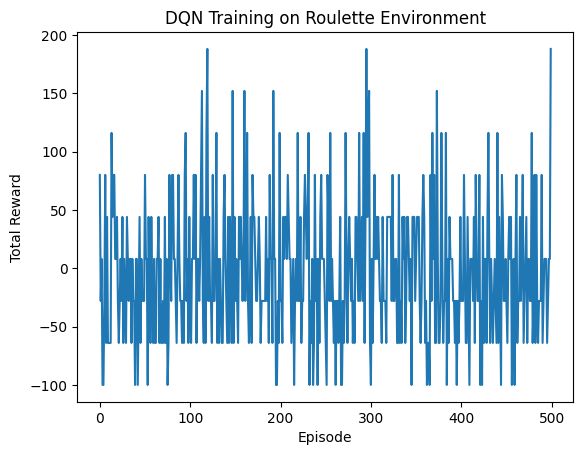

In [ ]:
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training on Roulette Environment')
plt.show()


torch.save(agent.policy_net.state_dict(), 'dqn_roulette.pth')


## RL and DRL for finding the shortest path in any user-input graph

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GraphShortestPathEnv(gym.Env):
    """
    Custom Gym environment for finding shortest path in a graph.
    States = nodes, Actions = edges, Rewards = -1 per step, +10 for goal.
    """
    def __init__(self, adjacency_dict, start_node, goal_node):
        super(GraphShortestPathEnv, self).__init__()
        self.graph = adjacency_dict
        self.nodes = list(adjacency_dict.keys())
        self.node_to_idx = {node: i for i, node in enumerate(self.nodes)}
        self.start_node = start_node
        self.goal_node = goal_node

        self.action_space = spaces.Discrete(len(self.nodes))
        self.observation_space = spaces.Discrete(len(self.nodes))
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_node = self.start_node
        return self.node_to_idx[self.current_node], {}

    def step(self, action):
        next_node = self.nodes[action]

        if next_node in self.graph[self.current_node]:
            self.current_node = next_node
            reward = 10 if next_node == self.goal_node else -1
        else:
            reward = -5  # invalid move penalty

        done = self.current_node == self.goal_node
        return self.node_to_idx[self.current_node], reward, done, False, {}

    def render(self):
        print(f"Current node: {self.current_node}")


In [ ]:
graph = {
    'A': ['B', 'C'],
    'B': ['D'],
    'C': ['D', 'E'],
    'D': ['F'],
    'E': ['F'],
    'F': []
}
start_node = 'A'
goal_node = 'F'
env = GraphShortestPathEnv(graph, start_node, goal_node)


### Classical Reinforcement Learning (Tabular Q-Learning)

In [ ]:
import random

num_states = env.observation_space.n
num_actions = env.action_space.n
Q_table = np.zeros((num_states, num_actions))

alpha = 0.1   # learning rate
gamma = 0.9   # discount factor
epsilon = 1.0 # exploration
epsilon_decay = 0.995
episodes = 300

rewards_tabular = []

for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0

    for _ in range(50):
        if random.random() < epsilon:
            action = random.randint(0, num_actions - 1)
        else:
            action = np.argmax(Q_table[state])

        next_state, reward, done, _, _ = env.step(action)
        best_next = np.max(Q_table[next_state])
        Q_table[state, action] += alpha * (reward + gamma * best_next - Q_table[state, action])

        state = next_state
        total_reward += reward
        if done:
            break

    epsilon *= epsilon_decay
    rewards_tabular.append(total_reward)


### Deep Reinforcement Learning (DQN)

In [ ]:
!

import random
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os

EPISODES = 500
MAX_STEPS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
UPDATE_TARGET_EVERY = 10



class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.policy_net = QNetwork(input_dim, output_dim).to(device)
        self.target_net = QNetwork(input_dim, output_dim).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = deque(maxlen=10000)
        self.epsilon = EPSILON_START
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            with torch.no_grad():
                state = np.array(state)
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state)
                return torch.argmax(q_values).item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample_experience(self):
        return random.sample(self.memory, BATCH_SIZE)

    def update(self):
        if len(self.memory) < BATCH_SIZE:
            return
        experiences = self.sample_experience()
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * GAMMA * next_q_values

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())




In [ ]:
state_dim = 1
action_dim = env.action_space.n

agent = DQNAgent(input_dim=state_dim, output_dim=action_dim)

rewards_drl = []

for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0

    for _ in range(50):
        state_tensor = np.array([state], dtype=np.float32)
        action = agent.select_action(state_tensor)
        next_state, reward, done, _, _ = env.step(action)

        next_state_tensor = np.array([next_state], dtype=np.float32)
        agent.store_experience(state_tensor, action, reward, next_state_tensor, done)
        agent.update()

        state = next_state
        total_reward += reward
        if done:
            break

    agent.epsilon = max(EPSILON_END, agent.epsilon * EPSILON_DECAY)
    if ep % UPDATE_TARGET_EVERY == 0:
        agent.update_target_network()

    rewards_drl.append(total_reward)


### Performance Comparison

In [ ]:
import pandas as pd

comparison_table = pd.DataFrame({
    'Metric': ['Average Reward', 'Convergence Episodes', 'Optimal Path Found (%)'],
    'RL (Q-learning)': [
        np.mean(rewards_tabular[-50:]),
        np.argmax(rewards_tabular),
        (sum(r > 0 for r in rewards_tabular[-50:]) / 50) * 100
    ],
    'DRL (DQN)': [
        np.mean(rewards_drl[-50:]),
        np.argmax(rewards_drl),
        (sum(r > 0 for r in rewards_drl[-50:]) / 50) * 100
    ]
})

print("\nPerformance Comparison (RL vs DRL):\n")
print(comparison_table)



Performance Comparison (RL vs DRL):

                   Metric  RL (Q-learning)  DRL (DQN)
0          Average Reward              4.2        4.4
1    Convergence Episodes              7.0       35.0
2  Optimal Path Found (%)             78.0       86.0


### Learning Curves

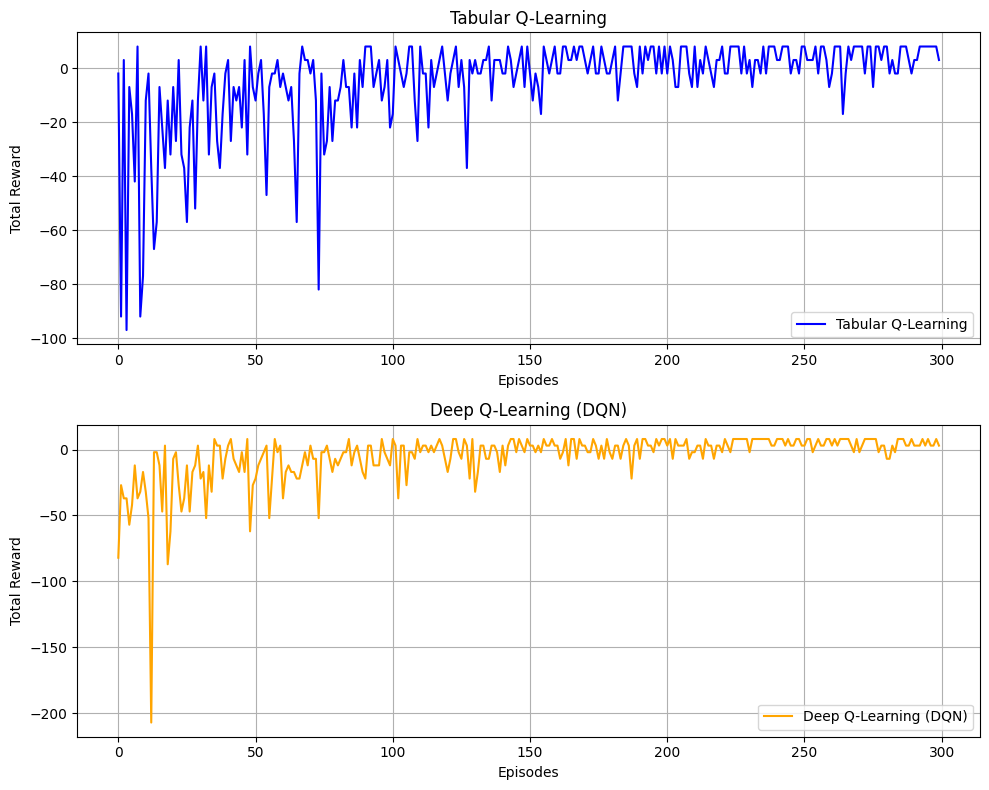

In [ ]:
import matplotlib.pyplot as plt

# --- Create Two Subplots ---
# (nrows, ncols, index)
# Create a figure with 2 rows and 1 column of plots
# figsize=(width, height)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# --- Plot 1: Tabular Q-Learning ---
ax1.plot(rewards_tabular, label='Tabular Q-Learning', color='blue')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Total Reward')
ax1.set_title('Tabular Q-Learning')
ax1.legend()
ax1.grid(True) # Add grid for readability

# --- Plot 2: Deep Q-Learning (DQN) ---
ax2.plot(rewards_drl, label='Deep Q-Learning (DQN)', color='orange')
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Total Reward')
ax2.set_title('Deep Q-Learning (DQN)')
ax2.legend()
ax2.grid(True) # Add grid for readability

# --- Show the Plots ---
plt.tight_layout() # Adjusts plots to prevent overlapping titles/labels
plt.show()